<a href="https://colab.research.google.com/github/TruscaPetre/AAIT-Nosy-Missing-Labels/blob/main/tutorial%20colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AAIT homework 2 - Training on labeled data

## Imports

In [1]:
import urllib
import shutil
import os
import time
import copy

import pandas as pd
import numpy as np

from PIL import Image
import matplotlib.pyplot as plt

import random

from tqdm import tqdm

import torchgen
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import SubsetRandomSampler, Dataset
from torchvision import transforms, datasets 

from sklearn.metrics import classification_report

import itertools

In [2]:
# Download data  

# extract the ID of the data
task1_id = "1dO1vqCoJm2xwrnr171A6_eW7ikd-alrd"
task2_id = "1GUF43k4PJX8YvNUWJbE1RnmXeI7nVbOL"


In [3]:
# replace here your ide &id=1iNTm3-9GSN2QjjITBi73ta73gDF_oacf"
# replace here your id 'https://docs.google.com/uc?export=download&id=1dO1vqCoJm2xwrnr171A6_eW7ikd-alrd'
# replace here your target name -O task1.tar.gz &&
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1dO1vqCoJm2xwrnr171A6_eW7ikd-alrd' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1dO1vqCoJm2xwrnr171A6_eW7ikd-alrd" -O task1.tar.gz && rm -rf /tmp/cookies.txt


--2022-12-28 18:00:09--  https://docs.google.com/uc?export=download&confirm=t&id=1dO1vqCoJm2xwrnr171A6_eW7ikd-alrd
Resolving docs.google.com (docs.google.com)... 172.217.214.139, 172.217.214.100, 172.217.214.138, ...
Connecting to docs.google.com (docs.google.com)|172.217.214.139|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0g-8k-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/164nkp6sk687uraai6ibem2nr2l1kgkn/1672250400000/08997952672865575084/*/1dO1vqCoJm2xwrnr171A6_eW7ikd-alrd?e=download&uuid=90b0d600-4a86-488a-aa69-a018bd63d2a5 [following]
--2022-12-28 18:00:09--  https://doc-0g-8k-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/164nkp6sk687uraai6ibem2nr2l1kgkn/1672250400000/08997952672865575084/*/1dO1vqCoJm2xwrnr171A6_eW7ikd-alrd?e=download&uuid=90b0d600-4a86-488a-aa69-a018bd63d2a5
Resolving doc-0g-8k-docs.googleusercontent.com (doc-0g-8k-docs.googleusercontent.com)... 172.217.212.

In [4]:
%%capture
!mkdir data
!mv task1.tar.gz ./data
!tar -xzvf "/content/data/task1.tar.gz" -C "/content/data/"     #[run this cell to extract tar.gz files]
# this may take 12 seconds

## Exploring the data 

In [5]:
dir_data = './data/task1/train_data/'
# Read the annotations file into a DataFrame
df = pd.read_csv(f'{dir_data}annotations.csv')

# Print the DataFrame
print(df)

                                           sample  label
0          task1/train_data/images/labeled/0.jpeg      0
1          task1/train_data/images/labeled/1.jpeg      1
2          task1/train_data/images/labeled/2.jpeg      2
3          task1/train_data/images/labeled/3.jpeg      3
4          task1/train_data/images/labeled/4.jpeg      4
...                                           ...    ...
23550  task1/train_data/images/labeled/23550.jpeg     97
23551  task1/train_data/images/labeled/23551.jpeg     28
23552  task1/train_data/images/labeled/23552.jpeg     53
23553  task1/train_data/images/labeled/23553.jpeg      9
23554  task1/train_data/images/labeled/23554.jpeg     90

[23555 rows x 2 columns]


In [6]:
# Get the unique values in the 'label' column
unique_labels = df['label'].unique()

# Print the unique values
print(unique_labels)

# Get the number of unique values in the 'label' column
num_unique_labels = df['label'].nunique()

# Print the number of unique values
print(f"There are {num_unique_labels} classes")

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
 96 97 98 99]
There are 100 classes


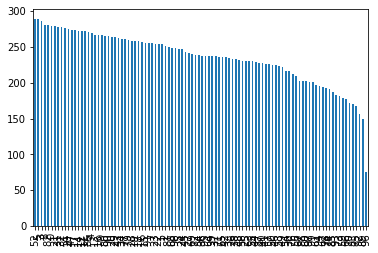

In [7]:

# Get the count of each class label
label_counts = df['label'].value_counts()
# Plot the label counts as a bar chart
label_counts.plot.bar()

## Training on the labeled data 
In order to prove that the semi-supervised learning task is superior to the supervised learning task. We should train the model first only on the samples that are labeled. Later if we see an improvement in the training where we take into account also the unlabeled data, compared to this example, we have proved the point.

Reference: 
- https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
- https://pytorch.org/hub/pytorch_vision_mobilenet_v2/

### Run the model

In [9]:
# Download a pytorch MobileNet pretrained model
model = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=True)
# change the Linear output
# print(model.classifier)
# > Sequential(
#   (0): Dropout(p=0.2)
#   (1): Linear(in_features=1280, out_features=1000, bias=True)
# )
model.classifier[1] = nn.Linear(1280, 100)
print(model.classifier)

Sequential(
  (0): Dropout(p=0.2, inplace=False)
  (1): Linear(in_features=1280, out_features=100, bias=True)
)


In [10]:
# sample execution (requires torchvision)
img_path = df.iloc[1]["sample"]
input_image = Image.open(f"data/{img_path}")
preprocess = transforms.Compose([
    transforms.Resize(224),
    # transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

# sanity check
print(input_batch.shape)

torch.Size([1, 3, 224, 224])


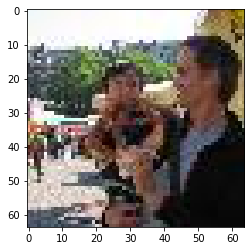

In [11]:
plt.imshow(input_image)

In [12]:
# move the input and model to GPU for speed if available
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    model.to('cuda')

with torch.no_grad():
    output = model(input_batch)
# Tensor of shape 100
print(output[0].shape)
# The output has unnormalized scores. To get probabilities, you can run a softmax on it.
probabilities = torch.nn.functional.softmax(output[0], dim=0) 
# select the maximum value to find the class predicted
print(f"predicted class: {torch.argmax(probabilities).item()}")
true_label = df.iloc[1]["label"]
print(f"true label: {true_label}")

torch.Size([100])
predicted class: 75
true label: 1


### Organize data for pytorch ImageFolder 

In [13]:
# Do this only once 
# Define the base directory
base_dir = 'data/task1/labeled'

# Iterate over the rows in the DataFrame
for _, row in tqdm(df.iterrows(), total=df.shape[0]):
    # Extract the path and class from the row
    path = row['sample']
    label = row['label']
    
    # Create the directory for the class
    class_dir = f'{base_dir}/{label}'
    os.makedirs(class_dir, exist_ok=True)
    
    # Copy the file to the class directory
    shutil.copy(f"data/{path}", class_dir) 


100%|██████████| 23555/23555 [00:05<00:00, 4436.12it/s]


In [15]:


# This will shuffle the images in the dataset 
# before they are returned to the data loader,
# which should help ensure that the validation and training sets
# are more balanced.
class ShuffledImageFolder(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
        self.indices = torch.randperm(len(dataset))

    def __getitem__(self, index):
        return self.dataset[self.indices[index]]

    def __len__(self):
        return len(self.dataset)

data_dir = 'data/task1/labeled'
image_dataset_unshuffled = datasets.ImageFolder(data_dir, preprocess)
image_dataset = ShuffledImageFolder(image_dataset_unshuffled)

# print(image_datasets)
# We don't want to create a single dataset because we want to have a dataset for evaluation also
# dataloader  = torch.utils.data.DataLoader(image_dataset, batch_size = 4, shuffle = True, num_workers = 4)

In [17]:
# split data into train and val

dataset_size = len(image_dataset)
print(dataset_size)
split = int(dataset_size*0.8)
train_size = split
print(train_size)
val_size = dataset_size - split
print(val_size)
assert val_size+train_size == dataset_size
class_names = image_dataset.dataset.classes

# Create a sampler for the training set
train_sampler = SubsetRandomSampler(range(split))

# Create a sampler for the valuation set
val_sampler = SubsetRandomSampler(range(split, dataset_size))

# Create DataLoaders for the training and valuation sets
train_dataloader = torch.utils.data.DataLoader(image_dataset, batch_size=32, sampler=train_sampler)
val_dataloader = torch.utils.data.DataLoader(image_dataset, batch_size=32, sampler=val_sampler, shuffle=False)
dataloaders = {
    "train":train_dataloader,
    "val":val_dataloader,
}
dataset_sizes = {
    "train":train_size,
    "val":val_size,
}
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

23555
18844
4711


### Visualize few images

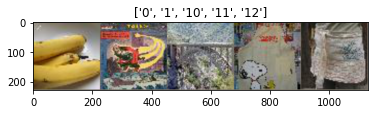

In [18]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs[:5])

imshow(out[:5], title=[class_names[x] for x in range(5)])

### Training the model

In [19]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [21]:
# Fine tuning

model = model.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [22]:
# TODO how can I make sure that I am only training the last layer
# and I am not training the whole model
# can I make sure that the all layers except last are frozen?

In [23]:
# TODO try to address the issue of imbalanced data, 
# There are classes with varying amounts of samples

In [24]:
model = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------


100%|██████████| 589/589 [01:47<00:00,  5.48it/s]


train Loss: 2.6203 Acc: 0.4041


100%|██████████| 148/148 [00:13<00:00, 10.66it/s]


val Loss: 1.5775 Acc: 0.6050

Epoch 1/24
----------


100%|██████████| 589/589 [01:44<00:00,  5.65it/s]


train Loss: 1.2846 Acc: 0.6789


100%|██████████| 148/148 [00:13<00:00, 11.32it/s]


val Loss: 1.2329 Acc: 0.6740

Epoch 2/24
----------


100%|██████████| 589/589 [01:44<00:00,  5.63it/s]


train Loss: 0.8227 Acc: 0.7940


100%|██████████| 148/148 [00:13<00:00, 11.10it/s]


val Loss: 1.1113 Acc: 0.6994

Epoch 3/24
----------


100%|██████████| 589/589 [01:43<00:00,  5.67it/s]


train Loss: 0.5318 Acc: 0.8694


100%|██████████| 148/148 [00:13<00:00, 11.03it/s]


val Loss: 1.0820 Acc: 0.7103

Epoch 4/24
----------


100%|██████████| 589/589 [01:45<00:00,  5.61it/s]


train Loss: 0.3273 Acc: 0.9281


100%|██████████| 148/148 [00:13<00:00, 10.82it/s]


val Loss: 1.0922 Acc: 0.7109

Epoch 5/24
----------


100%|██████████| 589/589 [01:44<00:00,  5.65it/s]


train Loss: 0.1918 Acc: 0.9628


100%|██████████| 148/148 [00:13<00:00, 10.97it/s]


val Loss: 1.1231 Acc: 0.7039

Epoch 6/24
----------


100%|██████████| 589/589 [01:45<00:00,  5.59it/s]


train Loss: 0.1226 Acc: 0.9793


100%|██████████| 148/148 [00:13<00:00, 10.77it/s]


val Loss: 1.1592 Acc: 0.7028

Epoch 7/24
----------


100%|██████████| 589/589 [01:44<00:00,  5.62it/s]


train Loss: 0.0626 Acc: 0.9937


100%|██████████| 148/148 [00:13<00:00, 10.97it/s]


val Loss: 1.0814 Acc: 0.7217

Epoch 8/24
----------


100%|██████████| 589/589 [01:44<00:00,  5.64it/s]


train Loss: 0.0424 Acc: 0.9981


100%|██████████| 148/148 [00:13<00:00, 11.38it/s]


val Loss: 1.0822 Acc: 0.7181

Epoch 9/24
----------


100%|██████████| 589/589 [01:43<00:00,  5.67it/s]


train Loss: 0.0351 Acc: 0.9990


100%|██████████| 148/148 [00:13<00:00, 11.17it/s]


val Loss: 1.0809 Acc: 0.7221

Epoch 10/24
----------


100%|██████████| 589/589 [01:43<00:00,  5.67it/s]


train Loss: 0.0303 Acc: 0.9992


100%|██████████| 148/148 [00:14<00:00, 10.12it/s]


val Loss: 1.0817 Acc: 0.7219

Epoch 11/24
----------


100%|██████████| 589/589 [01:44<00:00,  5.63it/s]


train Loss: 0.0264 Acc: 0.9994


100%|██████████| 148/148 [00:13<00:00, 11.18it/s]


val Loss: 1.0876 Acc: 0.7213

Epoch 12/24
----------


100%|██████████| 589/589 [01:44<00:00,  5.64it/s]


train Loss: 0.0226 Acc: 0.9998


100%|██████████| 148/148 [00:13<00:00, 11.11it/s]


val Loss: 1.0921 Acc: 0.7209

Epoch 13/24
----------


100%|██████████| 589/589 [01:44<00:00,  5.65it/s]


train Loss: 0.0204 Acc: 0.9997


100%|██████████| 148/148 [00:13<00:00, 11.33it/s]


val Loss: 1.0984 Acc: 0.7185

Epoch 14/24
----------


100%|██████████| 589/589 [01:43<00:00,  5.69it/s]


train Loss: 0.0178 Acc: 0.9996


100%|██████████| 148/148 [00:13<00:00, 11.30it/s]


val Loss: 1.0994 Acc: 0.7192

Epoch 15/24
----------


100%|██████████| 589/589 [01:44<00:00,  5.65it/s]


train Loss: 0.0166 Acc: 0.9999


100%|██████████| 148/148 [00:13<00:00, 11.11it/s]


val Loss: 1.0938 Acc: 0.7198

Epoch 16/24
----------


100%|██████████| 589/589 [01:43<00:00,  5.68it/s]


train Loss: 0.0163 Acc: 0.9998


100%|██████████| 148/148 [00:13<00:00, 11.10it/s]


val Loss: 1.0988 Acc: 0.7207

Epoch 17/24
----------


100%|██████████| 589/589 [01:44<00:00,  5.65it/s]


train Loss: 0.0162 Acc: 0.9997


100%|██████████| 148/148 [00:13<00:00, 11.28it/s]


val Loss: 1.0926 Acc: 0.7209

Epoch 18/24
----------


100%|██████████| 589/589 [01:43<00:00,  5.69it/s]


train Loss: 0.0156 Acc: 0.9999


100%|██████████| 148/148 [00:13<00:00, 11.22it/s]


val Loss: 1.1007 Acc: 0.7190

Epoch 19/24
----------


100%|██████████| 589/589 [01:44<00:00,  5.64it/s]


train Loss: 0.0154 Acc: 0.9998


100%|██████████| 148/148 [00:13<00:00, 11.19it/s]


val Loss: 1.1002 Acc: 0.7234

Epoch 20/24
----------


100%|██████████| 589/589 [01:43<00:00,  5.66it/s]


train Loss: 0.0154 Acc: 0.9999


100%|██████████| 148/148 [00:13<00:00, 11.10it/s]


val Loss: 1.1006 Acc: 0.7241

Epoch 21/24
----------


100%|██████████| 589/589 [01:44<00:00,  5.65it/s]


train Loss: 0.0149 Acc: 0.9999


100%|██████████| 148/148 [00:14<00:00, 10.40it/s]


val Loss: 1.0973 Acc: 0.7228

Epoch 22/24
----------


100%|██████████| 589/589 [01:46<00:00,  5.54it/s]


train Loss: 0.0143 Acc: 0.9999


100%|██████████| 148/148 [00:13<00:00, 10.76it/s]


val Loss: 1.1013 Acc: 0.7204

Epoch 23/24
----------


100%|██████████| 589/589 [01:46<00:00,  5.52it/s]


train Loss: 0.0144 Acc: 0.9999


100%|██████████| 148/148 [00:13<00:00, 10.88it/s]


val Loss: 1.0972 Acc: 0.7260

Epoch 24/24
----------


100%|██████████| 589/589 [01:45<00:00,  5.59it/s]


train Loss: 0.0144 Acc: 0.9999


100%|██████████| 148/148 [00:13<00:00, 10.66it/s]

val Loss: 1.1065 Acc: 0.7207

Training complete in 49m 13s
Best val Acc: 0.725961


### Visualize predictions

In [25]:
# Define the true labels and predicted labels
true_labels = []
predicted_labels = []

# Each epoch has a training and validation phase 
model.eval()   # Set model to evaluate mode 

# Iterate over data.
for inputs, labels in tqdm(dataloaders['val']):
    inputs = inputs.to(device)
    labels = labels.to(device)

    # forward
    with torch.set_grad_enabled(False): # we don't want to train
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1) 
    true_labels.append(labels)
    predicted_labels.append(preds)
 
 

100%|██████████| 148/148 [00:10<00:00, 14.10it/s]


In [26]:
true_labels_c = torch.cat(true_labels, dim=0).to("cpu")
predicted_labels_c = torch.cat(predicted_labels, dim=0).to("cpu")

In [27]:

# Convert the true_labels tensor into a list of integers
true_labels_list = [label.tolist() for label in true_labels_c]

# Convert the predicted_labels tensor into a list of integers
predicted_labels_list = [label.tolist() for label in predicted_labels_c]

In [ ]:
# I wished we could use a Confusion matrix,
# Unfortuneatly this method does not work, 
# because there are too many classes

#### Classification report 

In [29]:
# Generate the classification report
# report = classification_report(true_labels_list, true_labels_list, target_names=range(100), labels = class_names)
# report = classification_report(true_labels_list, true_labels_list, target_names=range(100), labels = [int(x) for x in class_names])
report = classification_report(true_labels_list, predicted_labels_list, target_names=class_names)

# Print the report
print(report)

              precision    recall  f1-score   support

           0       0.73      0.67      0.70        49
           1       0.89      0.83      0.86        47
          10       0.71      0.72      0.72        47
          11       0.85      0.78      0.81        50
          12       0.72      0.89      0.80        44
          13       0.73      0.76      0.75        62
          14       0.72      0.69      0.71        42
          15       0.73      0.68      0.71        53
          16       0.83      0.88      0.86        68
          17       0.46      0.65      0.53        48
          18       0.81      0.69      0.75        55
          19       0.88      1.00      0.93        42
           2       0.71      0.75      0.73        52
          20       0.81      0.82      0.82        51
          21       0.79      0.80      0.80        66
          22       0.75      0.89      0.81        53
          23       0.66      0.62      0.64        60
          24       0.82    